In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random, os
import numpy as np
import torch

C:\Users\basiu\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf 

In [3]:
import torchvision
from torchvision import transforms as T

In [4]:
import matplotlib.pyplot as plt

In [5]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

In [6]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")


X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


In [7]:
Y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
Y_train = Y_train.squeeze()
Y_test = Y_test.squeeze()

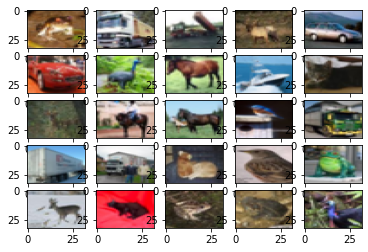

In [9]:
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1

plt.show()

In [10]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.resnet50 import preprocess_input

class CIFAR10ResNetGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x = x_data
        self.y = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]

        batch_x_resized = np.array([cv2.resize(img, (224, 224)) for img in batch_x]) #resizing the image 
        
        batch_x_preprocessed = preprocess_input(batch_x_resized.astype(np.float32)) #(s1,s2, channels) -> (batch, s1,s2, channels)

        return batch_x_preprocessed, batch_y


In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
train_gen = CIFAR10ResNetGenerator(X_train, Y_train, batch_size=32)
test_gen = CIFAR10ResNetGenerator(X_test, Y_test, batch_size=32, shuffle=False)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

Epoch 1/5


C:\Users\basiu\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3299s 2s/step - accuracy: 0.7544 - loss: 0.7428 - val_accuracy: 0.8778 - val_loss: 0.3573
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3230s 2s/step - accuracy: 0.8512 - loss: 0.4347 - val_accuracy: 0.8920 - val_loss: 0.3199
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3231s 2s/step - accuracy: 0.8636 - loss: 0.3912 - val_accuracy: 0.8856 - val_loss: 0.3237
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3243s 2s/step - accuracy: 0.8638 - loss: 0.3909 - val_accuracy: 0.8986 - val_loss: 0.2971
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3250s 2s/step - accuracy: 0.8725 - loss: 0.3673 - val_accuracy: 0.8924 - val_loss: 0.3083


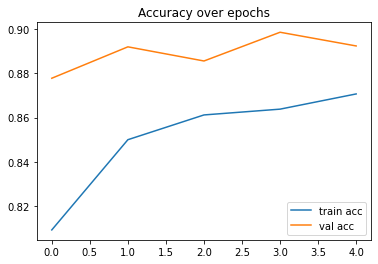

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [17]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


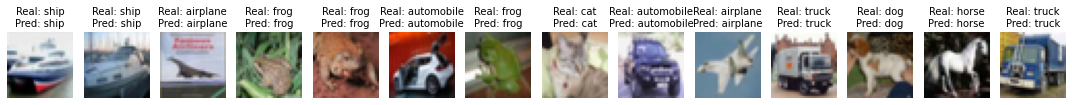

In [18]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))  # Adjust grid size dynamically

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10)

    plt.tight_layout()
    plt.show()
    
label_check(range(1,15))


In [19]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))  # Adjust grid size dynamically

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        #resize and preprocess for ResNet
        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


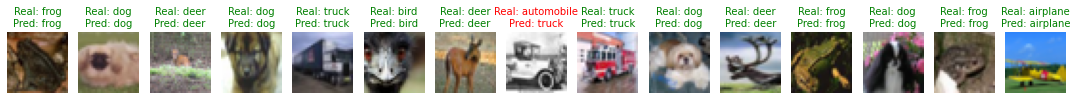

In [21]:
label_check(range(30,45))

In [24]:
model.save("resnet_model_final.keras")

In [26]:
model.save("resnet_model_final.h5")

In [25]:
#retrieving the model later
#from keras.models import load_model
#model = load_model("resnet_model_3.h5") 